Name: Shiska Raut <br>
ID:   1001526329

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
%matplotlib inline

## Read training/evaluation data

**Argument(s):** 
1) filename: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y) <br>
2) dtype_x : datatype of features <br>
3) dtype_y: datatype of label <br>

**Return(s):** 'X, Y' where X is a numpy array of feature vectors and Y is the target label vector.
Note: <br>
Each column in the array(s) epresents a single datapoint. <br>

In [2]:
def get_X_Y_arrays(filename, dtype_x, dtype_y):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()

    # initialize list to store feature and labels for training data
    features = []
    labels = []

    with f:
        line = f.readline()
        while line != '':
            # strip newline and outer parenthesis
            line = line.strip('\n')
            line = line.strip('( )')

            # extrace label and append to labels list
            single_label = line.split('), ')[-1]
            labels.append(single_label)

            # extrace features and append to features list
            feat = line.split('), ')[0].split(', ')
            features.append(feat)

            # read next line
            line = f.readline()

        # create dataframe of features and append labels
        X = np.array(features, dtype=dtype_x, ndmin=2)

        # convert labels list to array
        Y = np.array(labels, dtype=dtype_y)

        return X, Y

### Helper Functions

In [28]:
# splits data into training and test set
# first 6 datapoints become the test datapoints
def split_data(X, Y):

    n_test_items = 6

    X_test = X[0:n_test_items, :]
    Y_test = Y[0:n_test_items]

    X_train = np.delete(X, np.s_[0:n_test_items], axis = 0)
    Y_train = np.delete(Y, np.s_[0:n_test_items])

    return X_train, Y_train, X_test, Y_test


# compares two arrays and returns class accuracy
def get_class_acc(Y_pred, Y, decoding_dict):
    # create a dict to store class accuracy
    class_acc = {}

    # get all unique classes
    classes = set(Y.tolist())

    # get number of samples
    n_samples = Y_pred.shape[0]

    # calculate total occurence and accurate predictions for each class
    for c in classes:

        total = 0
        acc_vals = 0

        for i in range(n_samples):
            if Y[i] == c:
                total = total + 1
                if Y[i] == Y_pred[i]:
                    acc_vals = acc_vals + 1

        class_acc[decoding_dict[c]] = acc_vals / total

    # print(f'The class accuracy values are: {class_acc}')

    return class_acc


# compares two arrays and returns overall accuracy
def get_overall_acc(Y_pred, Y):

    n_samples = Y_pred.shape[0]

    acc = (np.sum(Y == Y_pred)) / n_samples

    # print(f'The overall accuracy is: {acc:0.3f}.')

    # return overall accuracy
    return acc


# given an array of categorical values, returns encoded index
def get_encoded_Y(Y):
    # get number of samples
    n_samp = Y.shape[0]

    # get all unique labels
    uniq_labels = set(Y.tolist())

    # create dictionary to store encodings
    encoding_dict = {}
    for i, label in enumerate(uniq_labels):
        encoding_dict[label] = i

    # get number of labels
    n_labels = len(uniq_labels)

    # create encoded arr
    encoded_arr = np.zeros(n_samp, dtype=np.int16)
    for i in range(n_samp):
        encoded_arr[i] = encoding_dict[Y[i]]

    # reverse dictionary for decoding
    inv_encoding_dict = {v: k for k, v in encoding_dict.items()}

    return encoded_arr, inv_encoding_dict


# splits a df into two based on a feature's threshold
def split_df(df, feat_name, threshold):

    # split df on threshold
    l_df = df[df[feat_name] <= threshold]
    r_df = df[df[feat_name] > threshold]

    return l_df, r_df


# returns the label of a leaf node given Y labels
def get_leaf_value(Y_ser):

    # return label with the highest count
    most_count = Y_ser.mode()[0]

    return most_count


# calculates entropy of the given array
def entropy(val_count):

    # get total classes and items
    n_classes = val_count.size
    n_samp = np.sum(val_count)

    # if the no of samples are 0 return 0
    if n_samp == 0:
        return 0

    # if any of the elements are 0, math.log will throw an error
    if not np.all(val_count):

        # initialize an array on ones
        val_count_non_zero = np.ones(val_count.size)

        # replace elements fo non-zero
        for n in range(n_classes):
            if val_count[n] != 0:
                val_count_non_zero[n] = val_count[n]

        # calculate entropy and return
        return -1*np.dot(val_count / n_samp, np.log2(val_count_non_zero / n_samp))

    else:
        # calculate entropy and return
        return -1*np.dot(val_count / n_samp, np.log2(val_count / n_samp))



# given a dataframe and a feature name, sorts the df and calculates thresholds
def get_thresholds(df, feat_name, n_samp):

    # sort dataframe according to the given label
    df_sorted = df.sort_values(feat_name, axis = 0, ascending = True, ignore_index = True)

    # initialize list to store threshold values
    thresholds = []
    ser = df_sorted[feat_name]

    for i in range(n_samp - 1):
        val = (ser[i] + ser[i+1])/2
        thresholds.append(val)

    return df_sorted, thresholds



# calculates the best threshold for a given feature
def get_best_threshold(df, feat_name, n_classes, label_name):

    # get number of samples and list of labels
    n_samp = df.count()[label_name]
    labels_list = df[label_name].unique().tolist()

    # get sorted df and thresholds
    df_sorted, thresholds = get_thresholds(df, feat_name, n_samp)

    # number of data items for each class on the left and right side of the treshold
    l_counts = np.zeros(n_classes, dtype = np.int16)
    r_counts =  np.zeros(n_classes, dtype = np.int16)

    # set all entropy values to maximum
    best_l_entropy = math.log(n_classes, 2)
    best_r_entropy = math.log(n_classes, 2)
    min_entropy = (best_l_entropy + best_r_entropy)/2
    best_threshold = thresholds[0]

    # for each threshold
    for thres_val in thresholds:
        # for each class
        for i, label in enumerate(labels_list):
            l_counts[i] = df_sorted[(df_sorted[label_name] == label) &
                                           (df_sorted[feat_name] <= thres_val)][feat_name].count()
            r_counts[i] = df_sorted[(df_sorted[label_name] == label) &
                                           (df_sorted[feat_name] > thres_val)][feat_name].count()

        l_entropy = entropy(l_counts)
        r_entropy = entropy(r_counts)
        weighted_entropy = (np.sum(l_counts)*l_entropy + np.sum(r_counts)*r_entropy)/n_samp
        if weighted_entropy < min_entropy:
            min_entropy = weighted_entropy
            best_l_entropy = l_entropy
            best_r_entropy = r_entropy
            best_threshold = thres_val

    return best_threshold, min_entropy, best_l_entropy, best_r_entropy


# calculates the best attribute to split a node on
def get_best_split(df, n_classes, entropy_p, label_name):

    # create a list of all attributes
    feat_list = df.columns[:-1].tolist()

    # will store index of best feature to split on
    best_feat_idx = 0

    # set all entropy values to maximum
    l_entropy = math.log(n_classes, 2)
    r_entropy = math.log(n_classes, 2)
    min_entropy = (l_entropy + r_entropy)/2

    # store results for all features in a list
    res_for_each_feat = []
    for feat in feat_list:
        res_for_each_feat.append(get_best_threshold(df, feat, n_classes, label_name))

    # get feature with minimum split entropy
    for i in range(len(feat_list)):
        if res_for_each_feat[i][1] < min_entropy:
            min_entropy = res_for_each_feat[i][1]
            best_feat_idx = i

    # calculate information gain and store entropy values
    info_gain = entropy_p - min_entropy
    best_feat = feat_list[best_feat_idx]
    best_thresh = res_for_each_feat[best_feat_idx][0]
    l_entropy = res_for_each_feat[best_feat_idx][2]
    r_entropy = res_for_each_feat[best_feat_idx][3]

    return best_feat, best_thresh, abs(info_gain), abs(l_entropy), abs(r_entropy)


### 3 b) Descision Tree and Node object implementation

In [4]:

class Node:
    def __int__(self, feat_name=None, threshold=None, node_entropy=None, l_node=None, r_node=None, class_label=None):

        self.feat_name = feat_name        # splitting feature
        self.threshold = threshold        # splitting threshold
        self.entropy = node_entropy       # entropy value of the node
        self.l_node = l_node              # left child node
        self.r_node = r_node              # left child node
        self.class_label = class_label    # class label if a left node, None means not a leaf node


class DTreeClassifier:
    def __init__(self, max_depth = float('inf'), min_samp_to_split = 2):

        # major attributes are root, mx_depth and min samples required for splitting
        self.root = None
        self.max_depth = max_depth
        self.min_samp_to_split = min_samp_to_split

    # recursively builds a descision tree classifier
    def build_desc_tree(self, df, label_name, curr_depth = 0):

        # get total number of classes, samples and class label
        labels_list = df[label_name].unique().tolist()
        n_classes = len(labels_list)
        n_samples = df.count()[label_name]

        # n_classes == 1 means the node is a leaf
        if n_classes > 1:

            # calculate entropy of parent
            p_val_counts = np.zeros(n_classes)
            for i, label in enumerate(labels_list):
                p_val_counts[i] = df[df[label_name] == label][label_name].count()
            entropy_p = entropy(p_val_counts)

            # only split if these criteria are met
            if n_samples > self.min_samp_to_split and curr_depth < self.max_depth:
                best_feat, best_thresh, max_info_gain, l_entropy, r_entropy = get_best_split(df, n_classes, entropy_p,
                                                                                       label_name)
                if max_info_gain > 0:
                    l_df, r_df = split_df(df, best_feat, best_thresh)
                    l_node = self.build_desc_tree(l_df, label_name, curr_depth + 1)
                    r_node = self.build_desc_tree(r_df, label_name, curr_depth + 1)

                    node = Node()
                    node.feat_name = best_feat
                    node.threshold = best_thresh
                    node.entropy = entropy_p
                    node.l_node = l_node
                    node.r_node = r_node
                    node.class_label = None
                    return node

        node = Node()
        node.class_label = get_leaf_value(df[label_name])

        return node

    # function to train descision tree
    def fit_data(self, df, label_name):

        self.root = self.build_desc_tree(df, label_name)


    # revurisvely traverses the tree and returns the predicted label
    def get_single_prediction(self, samp, t_node):

        # if node is a left return label
        if t_node.class_label is not None:
            return t_node.class_label

        # if less than threshold, call left tree, else call right tree
        if samp[t_node.feat_name][0] <= t_node.threshold:
            prediction = self.get_single_prediction(samp, t_node.l_node)
        else:
            prediction = self.get_single_prediction(samp, t_node.r_node)

        return prediction


    # predicts labels given a dataframe
    def predict_labels(self, df):

        n_samples = df.count()[0]
        predictions = np.zeros(n_samples)

        for n in range(n_samples):
            single_samp_df = pd.DataFrame(df.values[n].reshape(1, len(df.columns)),
                                          columns = df.columns)
            predictions[n] = self.get_single_prediction(single_samp_df, self.root)

        return predictions
    

### 3 c) Training and Testing

In [5]:
# READ FILE
fname = '2_data.txt'

# read data
X, Y = get_X_Y_arrays(fname, float, str)

# get encoded Y
encoded_Y, decoding_dict = get_encoded_Y(Y)

# split data into training and test
X_train, Y_train, X_test, Y_test = split_data(X, encoded_Y)

# create dataframes
df_train = pd.DataFrame(np.concatenate((X_train, Y_train.reshape(X_train.shape[0], 1)), axis=1),
                        columns=['height', 'diameter', 'weight', 'hue', 'labels'], dtype=np.float32)

df_test = pd.DataFrame(np.concatenate((X_test, Y_test.reshape(X_test.shape[0], 1)), axis=1),
                       columns=['height', 'diameter', 'weight', 'hue', 'labels'], dtype=np.float32)

#### View data and decoding dict

In [6]:
df_train.head(10)

,height,diameter,weight,hue,labels
0,0.050000,0.067191,0.108086,3.612651,2.0
1,0.097218,0.134276,0.530302,3.581389,2.0
2,0.082333,0.052483,0.207009,4.268849,2.0
3,0.053522,0.030000,0.100000,3.402305,2.0
4,0.092504,0.068184,0.422383,2.651294,1.0
5,0.142357,0.139163,0.471437,4.120488,0.0
6,0.076536,0.085016,0.263367,3.441823,2.0
7,0.168621,0.150000,0.597853,4.768459,0.0
8,0.162522,0.150000,0.582545,3.557087,0.0
9,0.078976,0.049397,0.151682,3.824761,2.0


In [20]:
decoding_dict

{0: 'Plastic', 1: 'Ceramic', 2: 'Metal'}

{0: 'Plastic', 1: 'Ceramic', 2: 'Metal'}


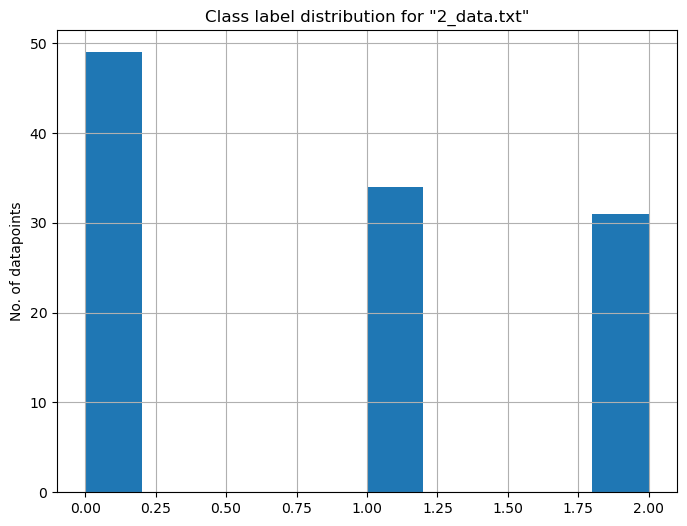

In [22]:
plt.figure(figsize = (8, 6))
plt.hist(Y_train)
plt.title(f'Class label distribution for "{fname}"')
plt.ylabel('No. of datapoints')
plt.grid()
print(decoding_dict)

In [24]:
df_test

,height,diameter,weight,hue,labels
0,0.103335,0.079225,0.187839,2.786577,0.0
1,0.185991,0.142774,0.608519,5.647819,0.0
2,0.066903,0.045010,0.118447,2.780018,2.0
3,0.128990,0.150000,0.433086,3.139230,0.0
4,0.050000,0.076688,0.178602,3.865847,2.0
5,0.134085,0.084665,0.271117,3.604623,0.0


### Create and train descision trees of depth 1 to 8

In [25]:
max_depth = 8
dtrees = []

# initialize tree objects
for d in range(1, max_depth + 1):
    dtrees.append(DTreeClassifier(max_depth = d))

# train trees
for i in range(len(dtrees)):
    dtrees[i].fit_data(df_train, 'labels')

### Predictions on training and test data

In [26]:
tr_predictions = []            # predictions for training data  
tst_predictions = []           # predictions for test data

for i in range(len(dtrees)):
    tr_predictions.append(dtrees[i].predict_labels(df_train.drop(['labels'], axis = 1)))
    tst_predictions.append(dtrees[i].predict_labels(df_test.drop(['labels'], axis = 1)))

### Caluclate accuracy values

In [27]:
tr_acc = []
tst_acc = []

for i in range(len(tr_predictions)):
    tr_acc.append(get_overall_acc(tr_predictions[i], Y_train))
    tst_acc.append(get_overall_acc(tst_predictions[i], Y_test))

The overall accuracy is: 0.605.
The overall accuracy is: 0.167.
The overall accuracy is: 0.684.
The overall accuracy is: 0.500.
The overall accuracy is: 0.737.
The overall accuracy is: 0.167.
The overall accuracy is: 0.833.
The overall accuracy is: 0.833.
The overall accuracy is: 0.886.
The overall accuracy is: 0.833.
The overall accuracy is: 0.904.
The overall accuracy is: 0.667.
The overall accuracy is: 0.965.
The overall accuracy is: 0.833.
The overall accuracy is: 0.974.
The overall accuracy is: 0.667.


### Plot Training and Test Accuracies

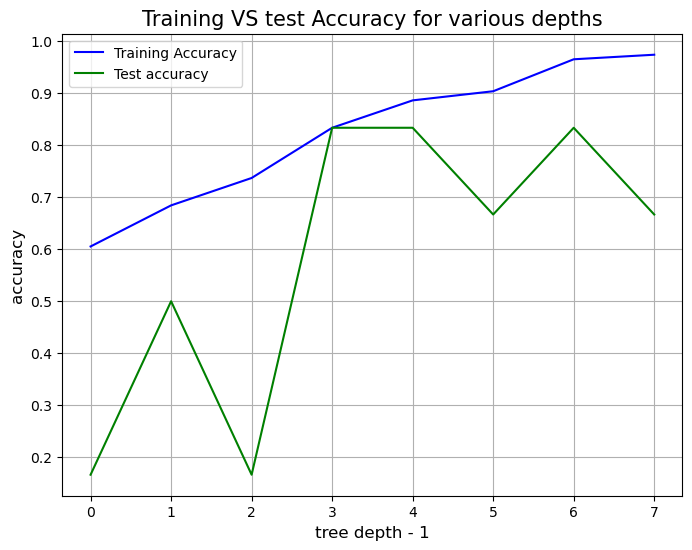

In [30]:
plt.figure(figsize = (8, 6))
plt.plot(tr_acc, color = 'blue')
plt.plot(tst_acc, color = 'green')
    
# add title, labels and legend
plt.title("Training VS test Accuracy for various depths", fontdict = {'fontsize': 15})
plt.legend(['Training Accuracy', 'Test accuracy'])
plt.xlabel("tree depth - 1", fontdict = {'fontsize': 12})
plt.ylabel("accuracy", fontdict = {'fontsize': 12})
plt.grid()

### Conclusion

The above figure shows that although "Training Accuracy" increases with tree depth, "Test Accuracy" decreases after a depth of 3. This is because it is fairy common for descision trees to overfit the data due to having a highly non-linear represenation. For the given data, the tree starts overfitting after around the depth of 3 as there is no improvement in test accuracy after that point. 